In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2
from typing import Any
from numpy import dtype, floating, ndarray
import numpy.random as rnd

## Forward Scattering

In [5]:
def circle_data(a: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the circle. Default is 0.0.
        cy (float): y-coordinate of the center of the circle. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        theta = (2 * np.pi / N) * i
        xn = cx + a * np.cos(theta)
        yn = cy + a * np.sin(theta)
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))  
    return data

def kite_data(a: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Generate coordinates for points on a kite shape.

    Args:
        a (float): Scaling factor for the kite.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the kite. Default is 0.0.
        cy (float): y-coordinate of the center of the kite. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y) of the kite points.
    """
    data = np.zeros((N, 2))
    for i in range(N):
        theta = (2 * np.pi / N) * i
        x = cx + a * (np.cos(theta) + 0.65 * np.cos(2*theta) - 0.65)
        y = cy + a * np.sin(theta)
        data[i, 0] = x
        data[i, 1] = y
    
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    return data

def rectangle_data(a: float, b: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Generate coordinates for points on a rectangle.

    Args:
        a (float): Length of the rectangle along the x-axis.
        b (float): Length of the rectangle along the y-axis.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the rectangle. Default is 0.0.
        cy (float): y-coordinate of the center of the rectangle. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y) of the rectangle points.
    """
    N = 4*(N//4)
    data = np.zeros((N, 2))
    # Points on the top side
    data[:N//4, 0] = np.linspace(cx - a/2, cx + a/2, N//4)
    data[:N//4, 1] = cy + b/2
    # Points on the right side
    data[N//4:N//2, 0] = cx + a/2
    data[N//4:N//2, 1] = np.linspace(cy + b/2, cy - b/2, N//4)
    # Points on the bottom side
    data[N//2:3*N//4, 0] = np.linspace(cx + a/2, cx - a/2, N//4)
    data[N//2:3*N//4, 1] = cy - b/2
    # Points on the left side
    data[3*N//4:, 0] = cx - a/2
    data[3*N//4:, 1] = np.linspace(cy - b/2, cy + b/2, N//4)
    
    return data

def data_ellypse(rx: float, ry: float, N: int) -> np.ndarray:
    """
    Generate coordinates for points on an ellipse.

    Args:
        rx (float): The radius of the ellipse along the x-axis.
        ry (float): The radius of the ellipse along the y-axis.
        N (int): The number of points to generate.

    Returns:
        np.ndarray: Array containing coordinates of points on the ellipse.
    """
    phi_stop = + np.pi - 2 * np.pi / N
    phi = np.linspace(- np.pi, phi_stop, N)
    data = np.zeros((N, 2))
    data[:, 0] = rx * np.cos(phi)
    data[:, 1] = ry * np.sin(phi)
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    return data

def is_inside_kite(x: np.ndarray, y: np.ndarray, data: np.ndarray) -> bool:
    """
    Check if the given point (x, y) is inside the geometry defined by data.

    Args:
        x (np.ndarray): Array of x-coordinates of the points.
        y (np.ndarray): Array of y-coordinates of the points.
        data (np.ndarray): Array defining the geometry.

    Returns:
        bool: True if the point is inside the geometry, False otherwise.
    """
    n = len(data)
    inside = False
    for i in range(n):
        j = (i + 1) % n
        if ((data[i, 1] > y) != (data[j, 1] > y)) and \
                (x < (data[j, 0] - data[i, 0]) * (y - data[i, 1]) / (data[j, 1] - data[i, 1]) + data[i, 0]):
            inside = not inside
    return inside

def is_inside_rectangle(x: np.ndarray, y: np.ndarray, data: np.ndarray) -> bool:
    """
    Check if points (x, y) are inside a rectangle defined by data.

    Parameters:
        x (np.ndarray): X-coordinates of the points.
        y (np.ndarray): Y-coordinates of the points.
        data (np.ndarray): Vertices of the rectangle (2x2 array).

    Returns:
        bool: True if points are inside the rectangle, False otherwise.
    """
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()

    inside = np.logical_and(x >= x_min, x <= x_max)
    inside = np.logical_and(inside, y >= y_min)
    inside = np.logical_and(inside, y <= y_max)
    
    return np.all(inside)

In [6]:
def calculate_current_distribution_aux_sources(data_contour: np.ndarray, data_aux: np.ndarray, phi_i: float) -> np.ndarray:
    """
    Calculate the current distribution for auxiliary sources.

    Args:
        data_contour: Contour data.
        data_aux: Auxiliary sources data.
        phi_i: Angle of incidence in degrees.

    Returns:
        ndarray: Current distribution for auxiliary sources.
    """
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    M = len(data_contour)  # Number of segments
    N = len(data_aux)  # Number of auxiliary sources
    Z = np.zeros((M, N), dtype=complex)  # Impedance matrix
    V = np.zeros((M, 1), dtype=complex)  # Excitation vector
    
    # Calculate impedance matrix
    for l in range(N):
        xm, ym = data_aux[l, 0], data_aux[l, 1]
        for m in range(M):
            xl, yl = data_contour[m, 0], data_contour[m, 1]
            rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
            Z[m, l] += hankel2(0, k * rml)

    # Calculate excitation vector
    for i in range(M):
        xm = data_contour[i, 0]
        ym = data_contour[i, 1]
        V[i] = np.exp(1j * k * (xm * np.cos(phi_i) + ym * np.sin(phi_i)))
    
    # Solve the least squares problem
    I, residuals, _, _ = np.linalg.lstsq(Z, -V, rcond=0.01)
    
    return I

In [7]:
def scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i] += hankel2(0, k * r) * I[j,0]
    return e_scat

def incident_field(xn_grid: np.ndarray, yn_grid: np.ndarray, phi_inc: float) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the incident field at observation points.

    Args:
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.
        phi_inc: Angle of incidence.

    Returns:
        ndarray: Incident field at observation points.
    """
    k = 2 * np.pi 
    N = len(xn_grid)
    phi_inc = np.deg2rad(phi_inc)  # Angle of incidence in radians
    e_inc = np.zeros((N, N), dtype=complex)  # Initialize incident field vector
    
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        e_inc[i] = np.exp(1j * k * (xn * np.cos(phi_inc) + yn * np.sin(phi_inc)))
    return e_inc   

def scattered_field_obs(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(xn_grid)
    M = len(data)
    e_scat = np.zeros((N,1), dtype=complex)  # Initialize scattered field vector

    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(M):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i,0] += hankel2(0, k * r) * I[j,0]
    return e_scat


In [8]:
# Plot the current distribution on the contour
a_contour = 3
a_aux = a_contour*0.9
M = 250
N = 100
data_contour = circle_data(a_contour, M)
data_aux = circle_data(a_aux, N)
phi_i = 0   # Angle of incidence in degrees

print("Number of matching points on the circle: ", M)
print("Number of auxiliary sources: ", N)

# Define the grid
grid_size = 500  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

# Calculate distance of each grid point from the center of the circle
distance_to_center = np.sqrt((x_grid)**2 + (y_grid)**2)

# Remove points within the circular region
mask = distance_to_center < a_contour
x_grid[mask] = np.nan
y_grid[mask] = np.nan

I_circle = calculate_current_distribution_aux_sources(data_contour, data_aux, phi_i)
e_scat_aux = scattered_field(data_aux, I_circle, x_grid, y_grid)
e_inc = incident_field(x_grid, y_grid, phi_i)
e_total = e_inc + e_scat_aux

Number of matching points on the circle:  250
Number of auxiliary sources:  100


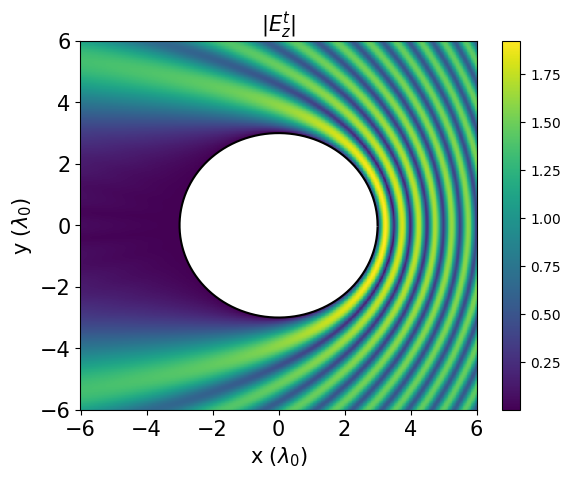

In [9]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [10]:
a_kite = 3
a_aux = a_kite*0.6
P = 400
N = 150
data_kite = kite_data(a_kite, P)
data_aux = circle_data(a_aux, N, cx=0.0, cy=0.0)
print("Number of matching points on the kite: ", P)
print("Number of auxiliary sources: ", N)

phi_i = [0, 180]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mask = np.zeros_like(x_grid, dtype=bool)
for i in range(grid_size):
    for j in range(grid_size):
        mask[i, j] = is_inside_kite(x_grid[i, j], y_grid[i, j], data_kite)

x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux_kite = np.zeros((grid_size, grid_size), dtype=complex)
e_inc_kite = np.zeros((grid_size, grid_size), dtype=complex)
e_total_kite = np.zeros((grid_size, grid_size), dtype=complex)
for i in range(J):
    I_kite = calculate_current_distribution_aux_sources(data_kite, data_aux, phi_i[i])
    e_scat_aux_kite += scattered_field(data_aux, I_kite, x_grid, y_grid)
    e_inc_kite += incident_field(x_grid, y_grid, phi_i[i])
e_total_kite = e_inc_kite + e_scat_aux_kite

Number of matching points on the kite:  400
Number of auxiliary sources:  150


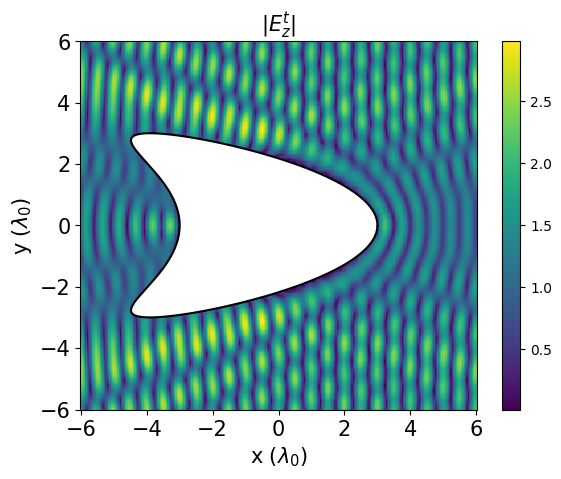

In [11]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total_kite), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_kite[:, 0], data_kite[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [12]:
a = 6  # Length of the rectangle along the x-axis
b = 4  # Length of the rectangle along the y-axis
cx = 0  # x-coordinate of the center of the rectangle
cy = 0  # y-coordinate of the center of the rectangle

# Find the radius inside the rectangle that is tangent to the circle
if a < b:
    a_aux = a*0.9/2
else:
    a_aux = b*0.9/2

N = 150
P = 400
data_rectangle = rectangle_data(a, b, P, cx, cy)
data_aux = circle_data(a_aux, N, cx, cy)

print("Number of matching points on the rectangle: ", P)
print("Number of auxiliary sources: ", N)

phi_i = [60, 120, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

mask = np.zeros_like(x_grid, dtype=bool)
for i in range(grid_size):
    for j in range(grid_size):
        mask[i, j] = is_inside_rectangle(x_grid[i, j], y_grid[i, j], data_rectangle)
x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux_rectangle = np.zeros((grid_size, grid_size), dtype=complex)
e_inc_rectangle = np.zeros((grid_size, grid_size), dtype=complex)
e_total_rectangle = np.zeros((grid_size, grid_size), dtype=complex)

e_total_rectangle_list = []
e_scat_aux_rectangle_list = []
for i in range(J):
    I_rectangle = calculate_current_distribution_aux_sources(data_rectangle, data_aux, phi_i[i])
    e_scat_aux_rectangle = scattered_field(data_aux, I_rectangle, x_grid, y_grid)
    e_inc_rectangle = incident_field(x_grid, y_grid, phi_i[i])
    e_total_rectangle = e_inc_rectangle + e_scat_aux_rectangle
    e_total_rectangle_list.append(e_total_rectangle)
    e_scat_aux_rectangle_list.append(e_scat_aux_rectangle)

Number of matching points on the rectangle:  400
Number of auxiliary sources:  150


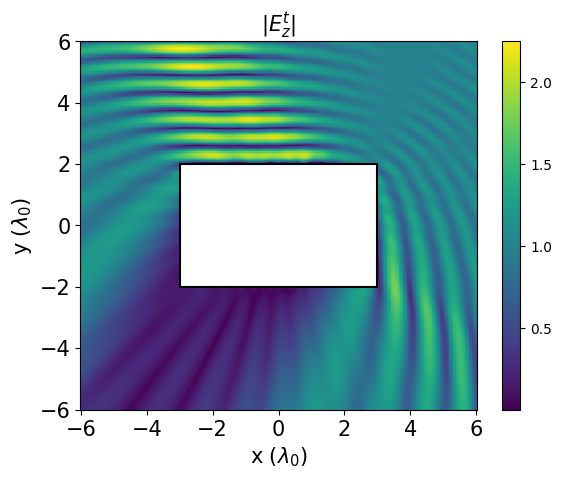

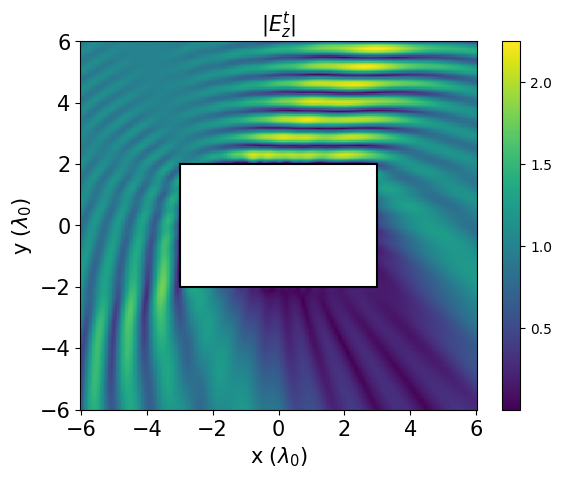

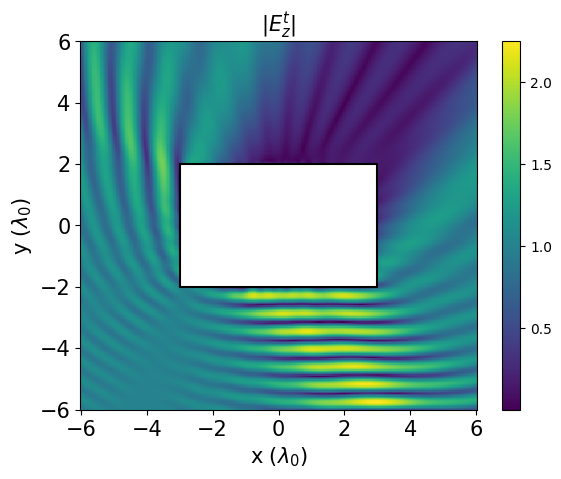

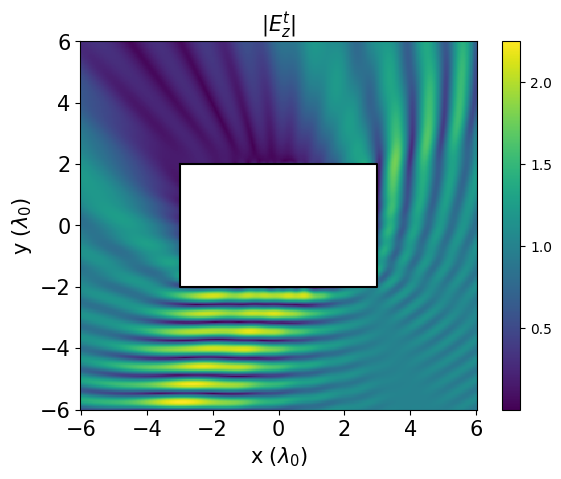

In [13]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.abs(e_total_rectangle_list[i]), shading='auto')
    plt.title(r'|$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.plot(data_rectangle[:, 0], data_rectangle[:, 1], color='black')  # Plot contour of the scatterer
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [14]:
a_sq = 5  # Length of the rectangle along the x-axis
b_sq = 5  # Length of the rectangle along the y-axis
cx = 0  # x-coordinate of the center of the rectangle
cy = 0  # y-coordinate of the center of the rectangle

# Find the radius inside the rectangle that is tangent to the circle
if a < b:
    a_aux = a*0.9/2
else:
    a_aux = b*0.9/2

N = 150
P = 400
data_square = rectangle_data(a_sq, b_sq, P, cx, cy)
data_aux = circle_data(a_aux, N, cx, cy)

print("Number of matching points on the rectangle: ", P)
print("Number of auxiliary sources: ", N)

phi_i = [60, 120, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

mask = np.zeros_like(x_grid, dtype=bool)
for i in range(grid_size):
    for j in range(grid_size):
        mask[i, j] = is_inside_rectangle(x_grid[i, j], y_grid[i, j], data_square)
x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux_square = np.zeros((grid_size, grid_size), dtype=complex)
e_inc_square = np.zeros((grid_size, grid_size), dtype=complex)
e_total_square = np.zeros((grid_size, grid_size), dtype=complex)

e_total_square_list = []
e_scat_aux_square_list = []
for i in range(J):
    I_square = calculate_current_distribution_aux_sources(data_square, data_aux, phi_i[i])
    e_scat_aux_square = scattered_field(data_aux, I_square, x_grid, y_grid)
    e_inc_square = incident_field(x_grid, y_grid, phi_i[i])
    e_total_square = e_inc_square + e_scat_aux_square
    e_total_square_list.append(e_total_square)
    e_scat_aux_square_list.append(e_scat_aux_square)

Number of matching points on the rectangle:  400
Number of auxiliary sources:  150


In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

for i in range(J):
    # plt.figure()
    # plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux_square_list[i]), shading='auto')
    # plt.title(r'|$E^{s}_{z}$|', fontsize=15)
    # plt.colorbar()
    # plt.plot(data_rectangle[:, 0], data_rectangle[:, 1], color='black')  # Plot contour of the scatterer
    # plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    # plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)
    # plt.show()

    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.abs(e_total_square_list[i]), shading='auto')
    plt.title(r'|$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.plot(data_square[:, 0], data_square[:, 1], color='black')  # Plot contour of the scatterer
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

## Inverse scattering 

In [16]:
def cv_inverse_scattering(data_obs: np.ndarray, data_aux: np.ndarray, scattered_field: np.ndarray, percentage: float = 1e-10) -> np.ndarray:
    """
    Computes the coefficient vector (cv) for inverse scattering.

    Args:
        data_obs (ndarray): Array containing coordinates of observable points.
        data_aux (ndarray): Array containing coordinates of auxiliary sources.
        scattered_field (ndarray): Scattered field.
        percentage (float): Percentage of the maximum singular value to determine J.

    Returns:
        ndarray: Coefficient vector.
        ndarray: Truncated impedance matrix.
    """
    M = len(data_obs)  # Number of observable points
    N = len(data_aux)  # Number of auxiliary sources
    k = 2 * np.pi  # Wavenumber
    Z = np.zeros((M, N), dtype=complex)
    
    for l in range(N):
        xm = data_aux[l, 0]
        ym = data_aux[l, 1]
        for m in range(M):
            xl = data_obs[m, 0]
            yl = data_obs[m, 1]
            rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
            Z[m,l] += hankel2(0, k * rml)
    # Solve the least squares problem
    cv, residuals, _, _ = np.linalg.lstsq(Z, scattered_field, rcond=1e-3)

    return cv, Z


In [17]:
def inverse_scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculates the inverse scattered field.

    Args:
        data (ndarray): Array containing coordinates of points on the contour.
        I (ndarray): Incident field vector.
        xn_grid (ndarray): x-coordinates grid.
        yn_grid (ndarray): y-coordinates grid.

    Returns:
        ndarray: Inverse scattered field vector.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_inv_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_inv_scat[i] += hankel2(0, k * r) * I[j]
    return e_inv_scat

def inverse_scattered_field_obs(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    M = len(xn_grid)
    N = len(data)
    e_inv_scat = np.zeros((M,1), dtype=complex)  # Initialize scattered field vector

    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_inv_scat[i] += hankel2(0, k * r) * I[j]
    return e_inv_scat

In [18]:
def add_noise(x, percentage):
    """Add noise to data.

    The noise is implemented as a complex number with a fixed magnitude
    and random phase.

    Parameters
    ----------
    x : array_like
        Data to receive noise.
    percentage : float
        Noise level in percentage.

    Returns
    -------
    xd : array_like
        Corrupted data with noise.
    """
    # Generate random phase
    phase = np.reshape(2 * np.pi * rnd.rand(x.size), x.shape)
    # Calculate noise magnitude
    mod = percentage / 100 * np.abs(x)
    # Add noise to the data
    xd = x + mod * np.cos(phase) + 1j * mod * np.sin(phase)
    return xd

### Circle

In [54]:
a_obs = a_contour + 3
a_aux = a_contour * 0.8
a_aux_forw = a_contour * 0.9

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_contour = circle_data(a_contour, M_points)
data_obs = circle_data(a_obs, M)
data_aux = circle_data(a_aux, N)
# Take only the points on the right side of the circle
# data_obs = data_obs[data_obs[:, 0] > 0]

print("Number of observable points on the circle: ", M)
print("Number of auxiliary sources: ", N)

x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 180]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)

for j in range(J):
    I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total += e_inv_inc + e_inv_scat

# e_inv_scat_log = np.log10(np.abs(e_inv_total))
# indices = np.where(x_grid[grid_size//2] > a_aux)[0]
# x_filtered = x_grid[grid_size//2, indices]
# e_filtered = e_inv_scat_log[grid_size//2, indices]

# # Plot the filtered data
# plt.figure()
# plt.plot(x_filtered, e_filtered)
# plt.title(r'Reconstructed $\log_{10}(|E^{t}_{z}$|) at y=0', fontsize=15)
# plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
# plt.ylabel(r'$\log_{10}(|E^{t}_{z}$|)', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# #plt.savefig("./Evaluation/Reconstructed_ETotal_y=0.png", bbox_inches='tight')
# plt.show()

# min_index = None
# min_value = np.inf
# for i in indices:
#     if e_inv_scat_log[grid_size//2, i] < min_value:
#         min_value = e_inv_scat_log[grid_size//2, i]
#         min_index = i

# x_coordinate = x_grid[grid_size//2, min_index]

# print("First minimum index:", min_index)
# print("First minimum value:", min_value)
# print("X-coordinate of the minimum value:", x_coordinate)

Number of observable points on the circle:  100
Number of auxiliary sources:  50


In [55]:
# Add noise to the scattered field and calculate SNR for only one incident angle
percentage = np.linspace(1, 20, 20)
phi_i = 0
snr_list_circle = []
for i in range(len(percentage)):
    I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i)
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    
    e_scat_noisy = add_noise(e_scat, percentage[i])
    cv_noisy, Z_noisy = cv_inverse_scattering(data_obs, data_aux, e_scat_noisy)
    e_inv_scat_noisy = inverse_scattered_field(data_aux, cv_noisy, x_grid, y_grid)
    
    snr = 10 * np.log10(np.sum(np.abs(e_inv_scat)**2) / np.sum(np.abs(e_inv_scat - e_inv_scat_noisy)**2))
    snr_list_circle.append(snr)

In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total)), shading='auto')
#plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.title(r'Reconstructed $log_{10}(|E^{t}_{z}$|)', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Save the figure as a pdf file
#plt.savefig("./Evaluation/FullObservation_2D_Circle_ETotal.png",bbox_inches='tight')
plt.show()

In [ ]:
a_obs = a_contour + 3 
a_aux_circ = np.linspace(0.1, 0.8, 8)*a_contour
a_aux_forw = a_contour * 0.9

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)

x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 180]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mean_error_lst_circle = []

# Find the x and y coordinates of the points on the circle contour in the x_grid and y_grid
x_contour = data_contour[:, 0]
y_contour = data_contour[:, 1]
x_contour_grid = np.zeros_like(x_contour, dtype=int)
y_contour_grid = np.zeros_like(y_contour, dtype=int)
for i in range(len(x_contour)):
    x_contour_grid[i] = np.argmin(np.abs(x_grid[0, :] - x_contour[i]))
    y_contour_grid[i] = np.argmin(np.abs(y_grid[:, 0] - y_contour[i]))
num_points = np.arange(len(x_contour_grid))

for i in range(len(a_aux_circ)):
    e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)
    data_aux = circle_data(a_aux_circ[i], N)
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
        e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
        e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
        e_inv_total += e_inv_inc + e_inv_scat
    mean_error = np.mean(np.abs(e_inv_total[x_contour_grid, y_contour_grid]**2))
    mean_error_lst_circle.append(mean_error)


In [ ]:
# Condition number depending on the number of auxiliary sources
a_obs = a_contour + 3 
a_aux = a_contour * 0.8
a_aux_forw = a_contour * 0.9

M = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)
N = np.arange(10, 1000, 25)
phi_i = [0]
J = len(phi_i)

cond_list_circle = []
for i in range(len(N)):
    data_aux = circle_data(a_aux, N[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_circle.append(cond)

In [ ]:
# Condition number depending on the number of observation points
a_obs = a_contour + 3 
a_aux = a_contour * 0.8
a_aux_forw = a_contour * 0.9

M = np.arange(10, 1000, 25)
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)


phi_i = [0]
J = len(phi_i)

cond_list_circle_M = []
for i in range(len(M)):
    data_obs = circle_data(a_obs, M[i])
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_circle_M.append(cond)

In [ ]:
# Condition number depending on the radius of the auxiliary curve
a_obs = a_contour + 3
a_aux = np.linspace(0.1, 0.8, 8)*a_contour
a_obs = a_contour + 3 
a_aux_forw = a_contour * 0.9

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)
phi_i = [0]
J = len(phi_i)

cond_list_circle_auxil = []
for i in range(len(a_aux)):
    data_aux = circle_data(a_aux[i], N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_circle_auxil.append(cond)

In [ ]:
# Compute the conditioning number for different observation radii on the circle
a_start = a_contour + 1
a_end = 10 * a_contour
a_obs = np.linspace(a_start, a_end, 18)
a_aux = a_contour*0.8
a_aux_forw = a_contour * 0.9

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
phi_i = [0]
J = len(phi_i)

cond_list_obs_circle = []
for i in range(len(a_obs)):
    data_obs = circle_data(a_obs[i], M)
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_contour, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_obs_circle.append(cond)

### Kite

In [46]:
a_obs = a_kite + 3
a_aux = a_kite * 0.5
a_aux_forw = a_kite * 0.6

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw, cx = 0.5, cy = 0.0)
data_kite = kite_data(a_kite, M_points)

data_obs = circle_data(a_obs, M)
data_aux = circle_data(a_aux, N, cx = 0.0, cy = 0.0)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340]
J = len(phi_i)

print("Number of auxiliary sources: ", N)
print("Number of observation points: ", M)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)

e_inv_scat_list = []
e_inv_total_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_scat_list.append(e_inv_scat)
    e_inv_total_list.append(e_inv_total)

Number of auxiliary sources:  50
Number of observation points:  100


In [47]:
# Add noise to the scattered field and calculate SNR for only one incident angle
percentage = np.linspace(1, 20, 20)
phi_i = 0
snr_list_kite = []
for i in range(len(percentage)):
    I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i)
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)

    e_scat_noisy = add_noise(e_scat, percentage[i])
    cv_noisy, Z_noisy = cv_inverse_scattering(data_obs, data_aux, e_scat_noisy)
    e_inv_scat_noisy = inverse_scattered_field(data_aux, cv_noisy, x_grid, y_grid)
    # Calculate SNR
    snr = 10 * np.log10(np.sum(np.abs(e_inv_scat)**2) / np.sum(np.abs(e_inv_scat - e_inv_scat_noisy)**2))
    snr_list_kite.append(snr)

In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
    
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig("./Evaluation/FullObservation_2D_Kite_ETotal_"+str(i)+".png",bbox_inches='tight')
    plt.show()

# Plot the total field sum
for i in range(J):
    if i == 0:
        e_total_kite_sum = e_inv_total_list[i]
    else:
        e_total_kite_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_kite_sum)), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [19]:
a_obs = a_kite + 3
a_aux_kite = np.linspace(0.1, 0.5, 8)*a_kite
a_aux_forw = a_kite*0.6

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw, cx=0.5, cy=0.0)
data_kite = kite_data(a_kite, M_points)
data_obs = circle_data(a_obs, M)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))


mean_error_lst_kite = []

x_contour = data_kite[:, 0]
y_contour = data_kite[:, 1]
x_contour_grid = np.zeros_like(x_contour, dtype=int)
y_contour_grid = np.zeros_like(y_contour, dtype=int)
for i in range(len(x_contour)):
    x_contour_grid[i] = np.argmin(np.abs(x_grid[0, :] - x_contour[i]))
    y_contour_grid[i] = np.argmin(np.abs(y_grid[:, 0] - y_contour[i]))
num_points = np.arange(len(x_contour_grid))


for i in range(len(a_aux_kite)):
    e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)
    data_aux = circle_data(a_aux_kite[i], N, cx = 0.0, cy = 0.0)
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
        e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
        e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
        e_inv_total += e_inv_inc + e_inv_scat
    mean_error = np.mean(np.abs(e_inv_total[x_contour_grid, y_contour_grid]**2))
    mean_error_lst_kite.append(mean_error)

In [ ]:
# Condition number depending on the number of auxiliary sources
a_obs = a_kite + 3
a_aux = a_kite * 0.5
a_aux_forw = a_kite * 0.6

M = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw, cx = 0.5, cy = 0.0)
data_kite = kite_data(a_kite, M_points)
data_obs = circle_data(a_obs, M)

N = np.arange(10, 1000, 25)
phi_i = [0]
J = len(phi_i)

cond_list_kite = []
for i in range(len(N)):
    data_aux = circle_data(a_aux, N[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_kite.append(cond)

In [ ]:
a_obs = a_kite + 3
a_aux = a_kite * 0.5
a_aux_forw = a_kite * 0.6

M_points = 400
N_forw = 150
M = np.arange(10, 1000, 25)
N = 50
data_aux_forw = circle_data(a_aux_forw, N_forw, cx=0.5, cy=0.0)
data_aux = circle_data(a_aux, N)
data_kite = kite_data(a_kite, M_points)

phi_i = [0]
J = len(phi_i)

cond_list_kite_M = []
for i in range(len(M)):
    data_obs = circle_data(a_obs, M[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_kite_M.append(cond)

In [ ]:
# Condition number depending on the radius of the auxiliary curve
a_obs = a_contour + 3
a_aux = np.linspace(0.1, 0.5, 8)*a_kite
a_aux_forw = a_kite*0.6

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw, cx=0.5, cy=0.0)
data_obs = circle_data(a_obs, M)
data_kite = kite_data(a_kite, M_points)
phi_i = [0]
J = len(phi_i)

cond_list_kite_auxil = []
for i in range(len(a_aux)):
    data_aux = circle_data(a_aux[i], N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_kite_auxil.append(cond)

In [ ]:
# Compute the conditioning number for different observation radii on the circle
a_start = a_kite + 1
a_end = 10 * a_kite
a_obs = np.linspace(a_start, a_end, 18)
a_aux = a_kite*0.5
a_aux_forw = a_kite * 0.6

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw, cx=0.5, cy=0.0)
data_kite = kite_data(a_kite, M_points)
phi_i = [0]
J = len(phi_i)

cond_list_obs_kite = []
for i in range(len(a_obs)):
    data_obs = circle_data(a_obs[i], M)
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_kite, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_obs_kite.append(cond)

### Rectangle

In [27]:
a_obs = a + 3
if a < b:
    a_aux = a*0.8/2
    a_aux_forw = a*0.9/2
else:
    a_aux = b*0.8/2
    a_aux_forw = b*0.9/2

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_rectangle = rectangle_data(a, b, M_points, cx = 0.0, cy = 0.0)
data_obs = circle_data(a_obs, M)
data_aux = circle_data(a_aux, N, cx = 0.0, cy = 0.0)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [60, 120, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)

e_inv_total_list = []
e_inv_scat_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total)
    e_inv_scat_list.append(e_inv_scat)

/tmp/ipykernel_1348020/305753572.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(np.sum(np.abs(e_scat)**2) / np.sum(np.abs(e_scat - e_scat_noisy)**2))


In [48]:
percentage = np.linspace(1, 20, 20)
phi_i = 0
snr_list_rect = []
for i in range(len(percentage)):
    I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i)
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)

    e_scat_noisy = add_noise(e_scat, percentage[i])
    cv_noisy, Z_noisy = cv_inverse_scattering(data_obs, data_aux, e_scat_noisy)
    e_inv_scat_noisy = inverse_scattered_field(data_aux, cv_noisy, x_grid, y_grid)
    # Calculate SNR
    snr = 10 * np.log10(np.sum(np.abs(e_inv_scat)**2) / np.sum(np.abs(e_inv_scat - e_inv_scat_noisy)**2))
    snr_list_rect.append(snr)

In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
    
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig("./Evaluation/FullObservation_2D_Rectangle_ETotal_"+str(i)+".png",bbox_inches='tight')
    plt.show()

for i in range(J):
    if i == 0:
        e_total_rectangle_sum = e_inv_total_list[i]
    else:
        e_total_rectangle_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_rectangle_sum)), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
a_obs = a + 3
a_aux_rect = np.linspace(0.1, 0.8, 8)*(b/2)
a_obs = a + 3
if a < b:
    a_aux_forw = a*0.9/2
else:
    a_aux_forw = b*0.9/2

M = 50
N = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, N)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [60, 120, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mean_error_lst_rect = []

# Find the x and y coordinates of the points on the rectangle contour in the x_grid and y_grid
x_contour = data_rectangle[:, 0]
y_contour = data_rectangle[:, 1]
x_contour_grid = np.zeros_like(x_contour, dtype=int)
y_contour_grid = np.zeros_like(y_contour, dtype=int)
for i in range(len(x_contour)):
    x_contour_grid[i] = np.argmin(np.abs(x_grid[0, :] - x_contour[i]))
    y_contour_grid[i] = np.argmin(np.abs(y_grid[:, 0] - y_contour[i]))
num_points = np.arange(len(x_contour_grid))

for i in range(len(a_aux_rect)):
    e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)
    data_aux = circle_data(a_aux_rect[i], N)
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
        e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
        e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
        e_inv_total += e_inv_inc + e_inv_scat
    mean_error = np.mean(np.abs(e_inv_total[x_contour_grid, y_contour_grid]**2))
    mean_error_lst_rect.append(mean_error)


In [ ]:
plt.figure()
plt.plot(a_aux, mean_error_lst_rect)
plt.xlabel(r'Radius of auxiliary curve ($\lambda_{0}$)', fontsize=15)
plt.ylabel(r'Average error at PEC boundary $|E^{t}_{z}/E_0|$', fontsize=15)
plt.title(r'Mean value of the total field along the contour $\partial \Omega$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
#plt.savefig("./Evaluation/MeanError_Contour_Rectangle.pdf",bbox_inches='tight')
plt.show()

In [ ]:
a_obs = a + 3
if a < b:
    a_aux = a*0.8/2
    a_aux_forw = a*0.9/2
else:
    a_aux = b*0.8/2
    a_aux_forw = b*0.9/2

M = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_rectangle = rectangle_data(a, b, M_points, cx = 0.0, cy = 0.0)
data_obs = circle_data(a_obs, M)
N = np.arange(10, 1000, 25)
phi_i = [0]
J = len(phi_i)

cond_list_rect = []
for i in range(len(N)):
    data_aux = circle_data(a_aux, N[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_rect.append(cond)

In [ ]:
a_obs = a + 3
if a < b:
    a_aux = a*0.8/2
    a_aux_forw = a*0.9/2
else:
    a_aux = b*0.8/2
    a_aux_forw = b*0.9/2

M_points = 400
N_forw = 150
M = np.arange(10, 1000, 25)
N = 50
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_aux = circle_data(a_aux, N)
data_rectangle = rectangle_data(a, b, M_points, cx = 0.0, cy = 0.0)

phi_i = [0]
J = len(phi_i)

cond_list_rect_M = []
for i in range(len(M)):
    data_obs = circle_data(a_obs, M[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_rect_M.append(cond)

In [ ]:
a_obs = a + 3
a_aux = np.linspace(0.1, 0.8, 8)*(b/2)
if a < b:
    a_aux_forw = a*0.9/2
else:
    a_aux_forw = b*0.9/2

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)
data_rectangle = rectangle_data(a, b, M_points, cx = 0.0, cy = 0.0)
phi_i = [0]
J = len(phi_i)

cond_list_rect_auxil = []
for i in range(len(a_aux)):
    data_aux = circle_data(a_aux[i], N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_rect_auxil.append(cond)

In [ ]:
# Compute the conditioning number for different observation radii on the circle
if a < b:
    a_aux = a*0.8/2
    a_aux_forw = a*0.9/2
    b_start = b + 1
    b_end = 10 * b
    a_obs = np.linspace(b_start, b_end, 18)
else:
    a_start = a + 1
    a_end = 10 * a
    a_obs = np.linspace(a_start, a_end, 18)
    a_aux = b*0.8/2
    a_aux_forw = b*0.9/2

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw, cx=0.5, cy=0.0)
data_rectangle = rectangle_data(a, b, M_points, cx = 0.0, cy = 0.0)
phi_i = [0]
J = len(phi_i)

cond_list_obs_rect = []
for i in range(len(a_obs)):
    data_obs = circle_data(a_obs[i], M)
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_rectangle, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_obs_rect.append(cond)

### Ellipse 

In [49]:
x_ellypse = 3
y_ellypse = 5

a_obs = y_ellypse + 3
a_aux_forw = 0.9 * x_ellypse
if x_ellypse < y_ellypse:
    a_aux_ellypse = np.linspace(0.1, 0.8, 8)*(x_ellypse)
else:
    a_aux_ellypse = np.linspace(0.1, 0.8, 8)*(y_ellypse)

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]
ellypse_data = data_ellypse(x_ellypse, y_ellypse, M_points)
phi_i = [0, 60, 90, 120, 180, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mean_error_lst_ellypse = []
e_inv_total_ellypse = np.zeros((grid_size, grid_size), dtype=complex)

# Find the x and y coordinates of the points on the rectangle contour in the x_grid and y_grid
x_contour = ellypse_data[:, 0]
y_contour = ellypse_data[:, 1]
x_contour_grid = np.zeros_like(x_contour, dtype=int)
y_contour_grid = np.zeros_like(y_contour, dtype=int)
for i in range(len(x_contour)):
    x_contour_grid[i] = np.argmin(np.abs(x_grid[0, :] - x_contour[i]))
    y_contour_grid[i] = np.argmin(np.abs(y_grid[:, 0] - y_contour[i]))
num_points = np.arange(len(x_contour_grid))

for i in range(len(a_aux_ellypse)):
    e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)
    data_aux = circle_data(a_aux_ellypse[i], N)
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
        e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
        e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
        e_inv_total += e_inv_inc + e_inv_scat
    mean_error = np.mean(np.abs(e_inv_total[x_contour_grid, y_contour_grid]**2))
    mean_error_lst_ellypse.append(mean_error)

In [50]:
percentage = np.linspace(1, 20, 20)
phi_i = 0
snr_list_ellypse = []
for i in range(len(percentage)):
    I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i)
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)

    e_scat_noisy = add_noise(e_scat, percentage[i])
    cv_noisy, Z_noisy = cv_inverse_scattering(data_obs, data_aux, e_scat_noisy)
    e_inv_scat_noisy = inverse_scattered_field(data_aux, cv_noisy, x_grid, y_grid)
    # Calculate SNR
    snr = 10 * np.log10(np.sum(np.abs(e_inv_scat)**2) / np.sum(np.abs(e_inv_scat - e_inv_scat_noisy)**2))
    snr_list_ellypse.append(snr)

In [ ]:
a_aux_inv = 0.8 * x_ellypse
e_inv_total_list = []

data_aux_inv = circle_data(a_aux_inv, N)
for j in range(J):
    I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux_inv, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux_inv, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total_ellypse = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total_ellypse)

In [ ]:
# Plot the total_field e_inv_total_ellypse on the grid
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    #plt.plot(ellypse_data[:, 0], ellypse_data[:, 1], color='black')  # Plot contour of the scatterer
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig("./Evaluation/FullObservation_2D_Ellypse_ETotal_"+str(i)+".png",bbox_inches='tight')
    plt.show()

# Plot the sum of the total field e_inv_total_ellypse on the grid
for i in range(J):
    if i == 0:
        e_total_ellypse_sum = e_inv_total_list[i]
    else:
        e_total_ellypse_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_ellypse_sum)), shading='auto')
#plt.plot(ellypse_data[:, 0], ellypse_data[:, 1], color='black')  # Plot contour of the scatterer
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
x_ellypse = 3
y_ellypse = 5

a_obs = y_ellypse + 3
a_aux_forw = 0.9 * x_ellypse
if x_ellypse < y_ellypse:
    a_aux = 0.8 * x_ellypse
else:
    a_aux = 0.8 * y_ellypse

M = 100
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, M)
ellypse_data = data_ellypse(x_ellypse, y_ellypse, M_points)
N = np.arange(10, 1000, 25)
phi_i = [0]
J = len(phi_i)

cond_list_ellypse = []
for i in range(len(N)):
    data_aux = circle_data(a_aux, N[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_ellypse.append(cond)

In [ ]:
x_ellypse = 3
y_ellypse = 5

a_obs = y_ellypse + 3
a_aux_forw = 0.9 * x_ellypse
if x_ellypse < y_ellypse:
    a_aux = 0.8 * x_ellypse
else:
    a_aux = 0.8 * y_ellypse

M_points = 400
N_forw = 150
M = np.arange(10, 1000, 25)
N = 50
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_aux = circle_data(a_aux, N)
ellypse_data = data_ellypse(x_ellypse, y_ellypse, M_points)

phi_i = [0]
J = len(phi_i)

cond_list_ellypse_M = []
for i in range(len(M)):
    data_obs = circle_data(a_obs, M[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_ellypse_M.append(cond)

In [ ]:
x_ellypse = 3
y_ellypse = 5
a_aux_forw = 0.9 * x_ellypse

if x_ellypse < y_ellypse:
    a_obs = y_ellypse + 3
    a_aux = np.linspace(0.1, 0.8, 8)*(x_ellypse)
else:
    a_obs = x_ellypse + 3
    a_aux = np.linspace(0.1, 0.8, 8)*(y_ellypse)

M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
ellypse_data = data_ellypse(x_ellypse, y_ellypse, M_points)
data_obs = circle_data(a_obs, M)
phi_i = [0]
J = len(phi_i)

cond_list_ellypse_auxil = []
for i in range(len(a_aux)):
    data_aux = circle_data(a_aux[i], N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_ellypse_auxil.append(cond)

In [ ]:
# Compute the conditioning number for different observation radii on the circle
a_aux_forw = 0.9 * x_ellypse
if x_ellypse < y_ellypse:
    a_start = y_ellypse + 1
    a_end = 10 * y_ellypse
    a_obs = np.linspace(a_start, a_end, 18)
    a_aux = 0.8*(x_ellypse)
else:
    a_start = x_ellypse + 1
    a_end = 10 * x_ellypse
    a_obs = np.linspace(a_start, a_end, 18)
    a_aux = 0.8*(y_ellypse)

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
ellypse_data = data_ellypse(x_ellypse, y_ellypse, M_points)
phi_i = [0]
J = len(phi_i)

cond_list_obs_ellypse = []
for i in range(len(a_obs)):
    data_obs = circle_data(a_obs[i], M)
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_obs_ellypse.append(cond)

### Square

In [51]:
a_obs = a_sq + 3
a_aux = a_sq * 0.8/2
a_aux_forw = a_sq * 0.9/2
M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_square = rectangle_data(a_sq, b_sq, M_points, cx = 0.0, cy = 0.0)
data_obs = circle_data(a_obs, M)
data_aux = circle_data(a_aux, N, cx = 0.0, cy = 0.0)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [60, 120, 240, 300]
J = len(phi_i)

print("Number of auxiliary sources: ", M)
print("Number of observation points: ", N)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)

e_inv_total_list = []
e_inv_scat_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i[j])
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total)
    e_inv_scat_list.append(e_inv_scat)

Number of auxiliary sources:  100
Number of observation points:  50


In [52]:
percentage = np.linspace(1, 20, 20)
phi_i = 0
snr_list_sq = []
for i in range(len(percentage)):
    I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i)
    e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
    cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)

    e_scat_noisy = add_noise(e_scat, percentage[i])
    cv_noisy, Z_noisy = cv_inverse_scattering(data_obs, data_aux, e_scat_noisy)
    e_inv_scat_noisy = inverse_scattered_field(data_aux, cv_noisy, x_grid, y_grid)
    # Calculate SNR
    snr = 10 * np.log10(np.sum(np.abs(e_inv_scat)**2) / np.sum(np.abs(e_inv_scat - e_inv_scat_noisy)**2))
    snr_list_sq.append(snr)

In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
    
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig("./Evaluation/FullObservation_2D_Square_ETotal_"+str(i)+".png",bbox_inches='tight')
    plt.show()

for i in range(J):
    if i == 0:
        e_total_square_sum = e_inv_total_list[i]
    else:
        e_total_square_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_square_sum)), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
a_aux_sq = np.linspace(0.1, 0.8, 8)*(b/2)
a_obs = a_sq + 3
a_aux_forw = a_sq*0.9/2

M = 50
N = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_obs = circle_data(a_obs, N)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [60, 120, 240, 300]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mean_error_lst_sq = []

# Find the x and y coordinates of the points on the rectangle contour in the x_grid and y_grid
x_contour = data_square[:, 0]
y_contour = data_square[:, 1]
x_contour_grid = np.zeros_like(x_contour, dtype=int)
y_contour_grid = np.zeros_like(y_contour, dtype=int)
for i in range(len(x_contour)):
    x_contour_grid[i] = np.argmin(np.abs(x_grid[0, :] - x_contour[i]))
    y_contour_grid[i] = np.argmin(np.abs(y_grid[:, 0] - y_contour[i]))
num_points = np.arange(len(x_contour_grid))

for i in range(len(a_aux_sq)):
    e_inv_scat = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_inc = np.zeros((grid_size, grid_size), dtype=complex)
    e_inv_total = np.zeros((grid_size, grid_size), dtype=complex)
    data_aux = circle_data(a_aux_sq[i], N)
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
        e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
        e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
        e_inv_total += e_inv_inc + e_inv_scat
    mean_error = np.mean(np.abs(e_inv_total[x_contour_grid, y_contour_grid]**2))
    mean_error_lst_sq.append(mean_error)


In [ ]:
a_obs = a_sq + 3
a_aux = a_sq * 0.8/2
a_aux_forw = a_sq * 0.9/2

M = 100
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_square = rectangle_data(a_sq, b_sq, M_points, cx = 0.0, cy = 0.0)
data_obs = circle_data(a_obs, M)
N = np.arange(10, 1000, 25)
phi_i = [0]
J = len(phi_i)

cond_list_sq = []
for i in range(len(N)):
    data_aux = circle_data(a_aux, N[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(ellypse_data, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_sq.append(cond)

In [ ]:
a_obs = a_sq + 3
a_aux = a_sq * 0.8/2
a_aux_forw = a_sq * 0.9/2

M_points = 400
N_forw = 150
M = np.arange(10, 1000, 25)
N = 50
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_aux = circle_data(a_aux, N)
data_square = rectangle_data(a_sq, b_sq, M_points, cx = 0.0, cy = 0.0)

phi_i = [0]
J = len(phi_i)

cond_list_square_M = []
for i in range(len(M)):
    data_obs = circle_data(a_obs, M[i])
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_square_M.append(cond)

In [ ]:
a_aux = np.linspace(0.1, 0.8, 8)*(b/2)
a_obs = a_sq + 3
a_aux_forw = a_sq*0.9/2
M = 100
N = 50
M_points = 400
N_forw = 150

data_aux_forw = circle_data(a_aux_forw, N_forw)
data_square = rectangle_data(a_sq, b_sq, M_points, cx = 0.0, cy = 0.0)
data_obs = circle_data(a_obs, M)
phi_i = [0]
J = len(phi_i)

cond_list_sq_auxil = []
for i in range(len(a_aux)):
    data_aux = circle_data(a_aux[i], N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_sq_auxil.append(cond)

In [ ]:
# Compute the conditioning number for different observation radii on the circle
a_start = a_sq + 1
a_end = 10 * a_sq
a_obs = np.linspace(a_start, a_end, 18)
a_aux_forw = a_sq*0.9/2
a_aux = a_sq * 0.8/2

M = 100
N = 50
M_points = 400
N_forw = 150
data_aux_forw = circle_data(a_aux_forw, N_forw)
data_square = rectangle_data(a_sq, b_sq, M_points, cx = 0.0, cy = 0.0)
phi_i = [0]
J = len(phi_i)

cond_list_obs_sq = []
for i in range(len(a_obs)):
    data_obs = circle_data(a_obs[i], M)
    data_aux = circle_data(a_aux, N)
    x_obs = data_obs[:, 0]
    y_obs = data_obs[:, 1]
    for j in range(J):
        I = calculate_current_distribution_aux_sources(data_square, data_aux_forw, phi_i[j])
        e_scat = scattered_field_obs(data_aux_forw, I, x_obs, y_obs)
        cv, Z = cv_inverse_scattering(data_obs, data_aux, e_scat)
    cond = np.linalg.cond(Z)
    cond_list_obs_sq.append(cond)

### Evaluation

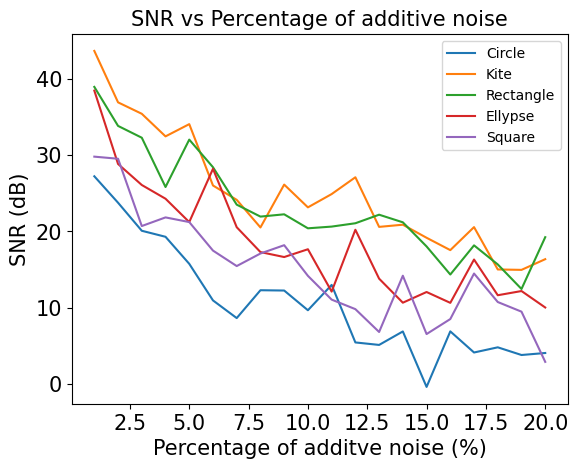

In [58]:
# Plot the SNR for different levels of noise
plt.figure()
plt.plot(percentage, snr_list_circle)
plt.plot(percentage, snr_list_kite)
plt.plot(percentage, snr_list_rect)
plt.plot(percentage, snr_list_ellypse)
plt.plot(percentage, snr_list_sq)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10)
plt.xlabel(r'Percentage of additve noise (%)', fontsize=15)
plt.ylabel(r'SNR (dB)', fontsize=15)
plt.title(r'SNR vs Percentage of additive noise', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("./Evaluation/SNR_vs_Noise_All.pdf",bbox_inches='tight')
plt.show()

In [ ]:
# Plot all mean errors of all geometries
plt.figure()
plt.plot(a_aux_circ, mean_error_lst_circle)
#plt.plot(a_aux_kite, mean_error_lst_kite)
#plt.plot(a_aux_rect, mean_error_lst_rect)
#plt.plot(a_aux_ellypse, mean_error_lst_ellypse)
#plt.plot(a_aux_sq, mean_error_lst_sq)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10)
plt.xlabel(r'Radius of auxiliary curve ($\lambda_{0}$)', fontsize=15)
plt.ylabel(r'Average error at PEC boundary $\langle|E^{t}_{z}/E_0|^2\rangle$', fontsize=15)
plt.title(r'Mean value of the total field along the contour $\partial \Omega$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("./Evaluation/MeanError_Contour_All.pdf",bbox_inches='tight')
plt.show()

In [ ]:
# Plot all condition numbers of all geometries
N = np.arange(10, 1000, 25)
plt.figure()
plt.plot(N, cond_list_circle)
plt.plot(N, cond_list_kite)
plt.plot(N, cond_list_rect)
plt.plot(N, cond_list_ellypse)
plt.plot(N, cond_list_sq)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10)
plt.title('Conditionning number as a function\nof the number of auxiliary sources', fontsize=15)
plt.xlabel(r'Number of auxiliary sources ($N^\prime$)', fontsize=15)
plt.ylabel(r'Conditionning number $\log_{10} (\kappa (A))$', fontsize=15)
plt.xticks(np.arange(0, 1100, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
#plt.savefig("./Evaluation/K_AuxiliarySources_All.pdf",bbox_inches='tight')
plt.show()


In [ ]:
M = np.arange(10, 1000, 25)
plt.figure()
plt.plot(M, cond_list_circle_M)
plt.plot(M, cond_list_kite_M)
plt.plot(M, cond_list_rect_M)
plt.plot(M, cond_list_ellypse_M)
plt.plot(M, cond_list_square_M)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10)
plt.title('Conditionning number as a function\nof the number of observation points', fontsize=15)
plt.xlabel(r'Number of observation points ($M^\prime$)', fontsize=15)
plt.ylabel(r'Conditionning number $\log_{10} (\kappa (A))$', fontsize=15)
plt.xticks(np.arange(0, 1100, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
#plt.savefig("./Evaluation/K_ObservationPoints_All.pdf",bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(a_aux, cond_list_circle_auxil)
plt.plot(a_aux, cond_list_kite_auxil)
plt.plot(a_aux, cond_list_rect_auxil)
plt.plot(a_aux, cond_list_ellypse_auxil)
plt.plot(a_aux, cond_list_sq_auxil)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10)
plt.title('Conditionning number as a function\nof the radius of the auxiliary curve', fontsize=15)
plt.xlabel(r'Radius of auxiliary curve ($\lambda_{0}$)', fontsize=15)
plt.ylabel(r'Conditionning number $\log_{10} (\kappa (A))$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
#plt.savefig("./Evaluation/K_R_AuxiliaryCurve_All.pdf",bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(a_obs, cond_list_obs_circle)
plt.plot(a_obs, cond_list_obs_kite)
plt.plot(a_obs, cond_list_obs_rect)
plt.plot(a_obs, cond_list_obs_ellypse)
plt.plot(a_obs, cond_list_obs_sq)
plt.legend([r'Circle', r'Kite', r'Rectangle', r'Ellypse', r'Square'], fontsize=10, bbox_to_anchor=(0.9, 0.6))
plt.title('Conditionning number as a function of the distance\nof observable curve from contour', fontsize=15)
plt.xlabel('Position of observable curve $\Gamma$ from center\nof coordinate system' +  r'($\lambda_{0}$)', fontsize=15)
plt.ylabel(r'Conditionning number $\log_{10} (\kappa (A))$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
#plt.savefig("./Evaluation/K_D_ObservableCurve_All.pdf",bbox_inches='tight')
plt.show()